# Imports

In [19]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
import seaborn as sns
import numpy as np
import datetime as dt
from collections import Counter
from dotenv import load_dotenv, find_dotenv
from urllib.parse import urljoin
import requests
from io import StringIO, BytesIO
import datetime as dt
import json

# Data

In [6]:
bike_df_all = pd.read_csv('data/bike_loans/bike_loans.csv', sep=';')#.drop(columns=['Importe', 
                                                              #        'DescripcionImporte', 
                                                              #      'operario'])
bike_df_all['Fecha_Prestamo'] = bike_df_all['Fecha_Prestamo'].astype('datetime64[ns]')
bike_df_all['Fecha_Devolucion'] = bike_df_all['Fecha_Devolucion'].astype('datetime64[ns]')

bike_df_all.dtypes
# bike_df_all = bike_df_all.dropna()
bike_df = bike_df_all[bike_df_all.Fecha_Devolucion <= '31/12/2019']
bike_df.shape

(11764276, 13)

In [ ]:
unique_stations = pd.read_csv('data/station_location_with_id.csv', sep=';').drop(columns=['photo', 'webDescription'])


In [7]:
# bike_df.operario.unique()

In [8]:
bike_df.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
dtype: object

# Weather

In [9]:
# API KEY
load_dotenv(find_dotenv())
OWM_API = os.environ.get("OWM_API")

In [16]:
## change data!
range_2019 = pd.DataFrame(pd.date_range('2019-01-01', '2019-12-31', freq='h'), columns=['hour'])
range_2019.tail().hour

8732   2019-12-30 20:00:00
8733   2019-12-30 21:00:00
8734   2019-12-30 22:00:00
8735   2019-12-30 23:00:00
8736   2019-12-31 00:00:00
Name: hour, dtype: datetime64[ns]

In [11]:
tail = range_2019.tail().hour
tail.max()

Timestamp('2021-05-01 00:00:00')

In [153]:
req = 'http://history.openweathermap.org/data/2.5/history/wdl'
start = range_2019.hour.min().value
inter = range_2019.hour[50].value
end = range_2019.hour.max().value
# tail1 = tail.min().value
# tail2 = tail.max().value
params = {
    'id':'3674962', # ID of medellin
    'type':'hour',
    'start':str(start)[:10], # unix time
    'end':str(end)[:10],
    'appid': OWM_API
}

r = requests.get(req, params=params)


# with open('data/weather.txt', 'w') as outfile:
#     json.dump(r.json(), outfile)
    
weather = r.json()
lst = weather.get('list')
dct = {x.get('dt'):x.get('weather')[0].get('main') for x in lst}
weather_df = pd.DataFrame.from_dict(dct, 
                                    orient='index', 
                                    columns=['weather']).reset_index().rename(columns={'index':'time'})
weather_df['rain'] = weather_df.weather == 'Rain'

weather_df.to_csv('data/weather.csv')

In [69]:
weather_df.head()

,time,weather,rain
0,2019-01-01 01:00:00,Clouds,False
1,2019-01-01 02:00:00,Clouds,False
2,2019-01-01 03:00:00,Clouds,False
3,2019-01-01 04:00:00,Clouds,False
4,2019-01-01 05:00:00,Clouds,False


# analyse

In [77]:
bikes_19 = bike_df_all[bike_df_all.Fecha_Devolucion.dt.year == 2019].reset_index()

In [78]:
# assign df a individual hour of the year per row
# ~30secs
def get_hr(x):
    time = x
    hour = dt.datetime(time.year, time.month,time.day,time.hour)
    return hour
    
bikes_19.loc[:,'hour_dropoff'] = bikes_19.Fecha_Devolucion.apply(get_hr) # get hr of dropoff
bikes_19.loc[:,'hour_pickup'] = bikes_19.Fecha_Prestamo.apply(get_hr) # get hr of pickup

In [79]:
# make sure df is sorted chronologically
bikes_19 = bikes_19.sort_values(by='Fecha_Devolucion')

# list all the appearing bikes and stations per individual hour of the year
bikes_19_drops = bikes_19.copy().groupby('hour_dropoff').agg({'Id_Aparcamiento_Destino':lambda x: list(x)}) # list only the stations which had interaction moved
bikes_19_picks = bikes_19.copy().groupby('hour_pickup').agg({'Id_Aparcamiento_Origen':lambda x: list(x)})
bikes_19_agg = bikes_19_drops.join(bikes_19_picks) # merge on the matching hour (some bikes are picked up in a different hour)
idx = bikes_19_agg.Id_Aparcamiento_Origen != bikes_19_agg.Id_Aparcamiento_Origen
bikes_19_agg.loc[idx, 'Id_Aparcamiento_Origen'] = [{-99:0} for i in idx if i] # pad hours with no pickup. .fillna() doesnt work (lists are recognized as NaN)

# compute the init state of all bikes prior to 2019 to get a starting balance of bikes
# we assume that the bike in its last position wasn't 'touched', thus remained in the station until the 02.01.2019
bikes_pre = bikes_pre.sort_values(by='Fecha_Devolucion', ascending=False) # walk backwards through df to find 'last' position of each bike
stations_init_df = bikes_pre.groupby('Id_Tag_Bicicleta').agg({'Id_Aparcamiento_Destino':'first'}) # first means last in this case

# count the bikes at the stations
stations_init_pre = Counter({i:0 for i in unique_stations.ID}) # pad the non appearing ones from the stations df
stations_init_pre.update(Counter(dict(stations_init_df.Id_Aparcamiento_Destino.value_counts()))) # fill up the stations

In [80]:
# Only run once, the .update method will always add +1 bike per iteration
# reset bikes_19_drops otherwise
bikes_19_agg['drops'] = None
bikes_19_agg['picks'] = None
bikes_19_agg['station_count'] = None

for c, row in bikes_19_agg.iterrows():
#     print(c)
    drops = Counter(row.Id_Aparcamiento_Destino) # count all dropoffs per hour
    picks = Counter(row.Id_Aparcamiento_Origen) # count all pickups per hour
#     stations_init_pre.update(drops) # add dropped bikes
#     stations_init_pre.subtract(picks) # subtract picked up bikes
#     bikes_19_agg.at[c, 'station_count'] = dict(stations_init_pre)
    bikes_19_agg.at[c, 'drops'] = dict(drops)
    bikes_19_agg.at[c, 'picks'] = dict(picks)
    
# move hour to columns and only leave the dict
bikes_19_agg = bikes_19_agg.reset_index()[['hour_dropoff', 'drops', 'picks', 'station_count']]

In [85]:
# bikes_19_agg

In [83]:
# pad the df with all hours of 2019
range_2019 = pd.DataFrame(pd.date_range('2019-01-02', '2019-12-31', freq='h'), columns=['hour'])
bikes_19_pad = range_2019.merge(bikes_19_agg, left_on='hour', right_on='hour_dropoff', how='left').drop(columns='hour_dropoff')


In [84]:
bikes_19_pad

,hour,drops,picks
0,2019-01-02 00:00:00,NaN,NaN
1,2019-01-02 01:00:00,NaN,NaN
2,2019-01-02 02:00:00,NaN,NaN
3,2019-01-02 03:00:00,NaN,NaN
4,2019-01-02 04:00:00,NaN,NaN
...,...,...,...
8708,2019-12-30 20:00:00,"{64.0: 5, 7.0: 11, 99.0: 4, 36.0: 3, 12.0: 18,...","{12: 2, 2: 6, 24: 3, 28: 1, 39: 5, 45: 2, 97: ..."
8709,2019-12-30 21:00:00,"{89.0: 2, 21.0: 1, 1.0: 11, 50.0: 6, 11.0: 3, ...","{5: 1, 10: 1, 28: 1, 54: 1}"
8710,2019-12-30 22:00:00,"{7.0: 6, 36.0: 1, 56.0: 1, 3.0: 1, 97.0: 1, 10...","{54: 1, 8: 1, 6: 1, 50: 1}"
8711,2019-12-30 23:00:00,"{101.0: 2, 44.0: 2, 95.0: 1, 21.0: 1, 20.0: 1,...",{-99: 0}


In [ ]:
# create picks df
picks_dict = dict(bikes_19_pad.picks)
picks_df = pd.DataFrame(picks_dict).T

In [151]:
# picks_df

# Put to notebook

In [99]:
bikes_19_pad = bikes_19_pad.merge(weather_df[['time', 'rain']], left_on='hour', right_on='time').drop(columns='time')


In [103]:

# copy only this
picks_df['hour'] = bikes_19_pad.hour.dt.hour
picks_df['rain'] = bikes_19_pad.rain


In [139]:
# plot the 4 most important stations
include = [8, 66, 7, 89, 'hour', 'rain']
picks_df = picks_df.loc[:,include]

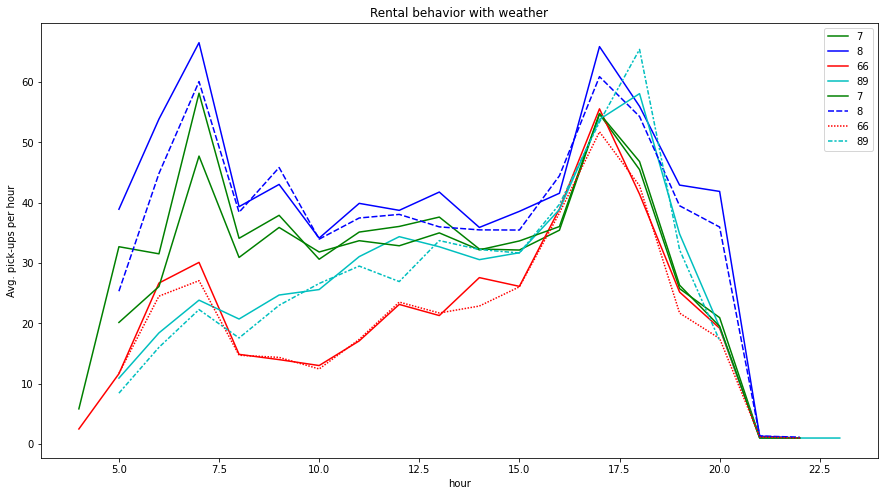

Station 89 (Málaga) behaves unusual at 17h. There are more rentals with rain than without.


In [144]:
rain_picks = picks_df.groupby(['rain', 'hour']).mean().loc[True,:]
nrain_picks = picks_df.groupby(['rain', 'hour']).mean().loc[False,:]
clrs = ['g', 'b', 'r', 'c']
plt.figure(figsize=(15,8))
sns.lineplot(data=nrain_picks, dashes=False, palette=clrs)
sns.lineplot(data=rain_picks, dashes=True, palette=clrs)
plt.title('Rental behavior with weather')
plt.ylabel('Avg. pick-ups per hour')
plt.show()
print(f'Station 89 ({unique_stations[unique_stations.ID == 89]["Description"].values[0]}) behaves unusual at 17h. There are more rentals with rain than without.')